# Neighborhood-Level Efficiency Explorer Data Processing
##### This notebook is intended to serve as a development environment for a processing script\* that will sit between our SCUBA database and CARTO's database.
##### \*The Python script in the diagram below

In [245]:
from IPython.display import Image
Image("img/hood_efficiency_data_flows.png")

---

## Setup

In [55]:
# import packages
import psycopg2 as pg
import pandas.io.sql as psql

# connect to database
database = "scuba"
user = "dmarulli"
password = "dmarulliStartPass"
host = "cadc.cmkjdlb3gfiw.us-west-2.rds.amazonaws.com"
port = 5432 

connection = pg.connect(database=database,
                        user=user,
                        password=password,
                        host=host,
                        port=port
                        )

## Extract (pull component data from SCUBA)

In [56]:
# usage
query = "select * from usage LIMIT 10"
usageDF =  psql.read_sql(query, connection)

# cust_loc
query = "select * from cust_loc LIMIT 10"
cust_locDF = psql.read_sql(query, connection)

# census_block_polygons_2010
query = "select * from census_block_polygons_2010 LIMIT 10"
census_block_polygons_2010DF = psql.read_sql(query, connection)

# et_reading
query = "select * from et_reading LIMIT 10"
et_readingDF = psql.read_sql(query, connection)

## Transform

## Load (push processed data to CARTO)

Step 1: Drop old table

In [155]:
%%bash

key="dae2d77d6d8f40911576008b6159585c99ab6556" \
sql="DROP+TABLE+mnwd_census_block_usage_test" \
url="http://california-data-collaborative.carto.com:80/api/v2/sql?api_key=$key&q=$sql"
curl $url

{"rows":[],"time":0.026,"fields":{},"total_rows":0}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    51  100    51    0     0     69      0 --:--:-- --:--:-- --:--:--   184


Step 2: Manually refresh account (to update account metadata)

Step 3: Load new table

In [1]:
%%bash

curl -F file=@./tempOUT/mnwd_census_block_usage_test.csv \
"https://california-data-collaborative.carto.com/api/v1/imports/?api_key=dae2d77d6d8f40911576008b6159585c99ab6556"

{"item_queue_id":"c9d61ce3-f633-4d2d-9909-2b7ca96ce8da","success":true}

*   Trying 52.21.187.176...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0* Connected to california-data-collaborative.carto.com (52.21.187.176) port 443 (#0)
* ALPN, offering http/1.1
* Cipher selection: ALL:!EXPORT:!EXPORT40:!EXPORT56:!aNULL:!LOW:!RC4:@STRENGTH
* successfully set certificate verify locations:
*   CAfile: /Users/davidmarulli/anaconda2/ssl/cacert.pem
  CApath: none
* TLSv1.2 (OUT), TLS header, Certificate Status (22):
} [5 bytes data]
* TLSv1.2 (OUT), TLS handshake, Client hello (1):
} [512 bytes data]
* TLSv1.2 (IN), TLS handshake, Server hello (2):
{ [107 bytes data]
* NPN, negotiated HTTP1.1
{ [5 bytes data]
* TLSv1.2 (IN), TLS handshake, Certificate (11):
{ [3249 bytes data]
* TLSv1.2 (IN), TLS handshake, Server key exchange (12):
{ [333 bytes data]
* TLSv1.2 (IN), TLS handshake

Step 4: Manually refresh account (to update account metadata)

---
## References
##### Below is SCUBA's current schema for reference

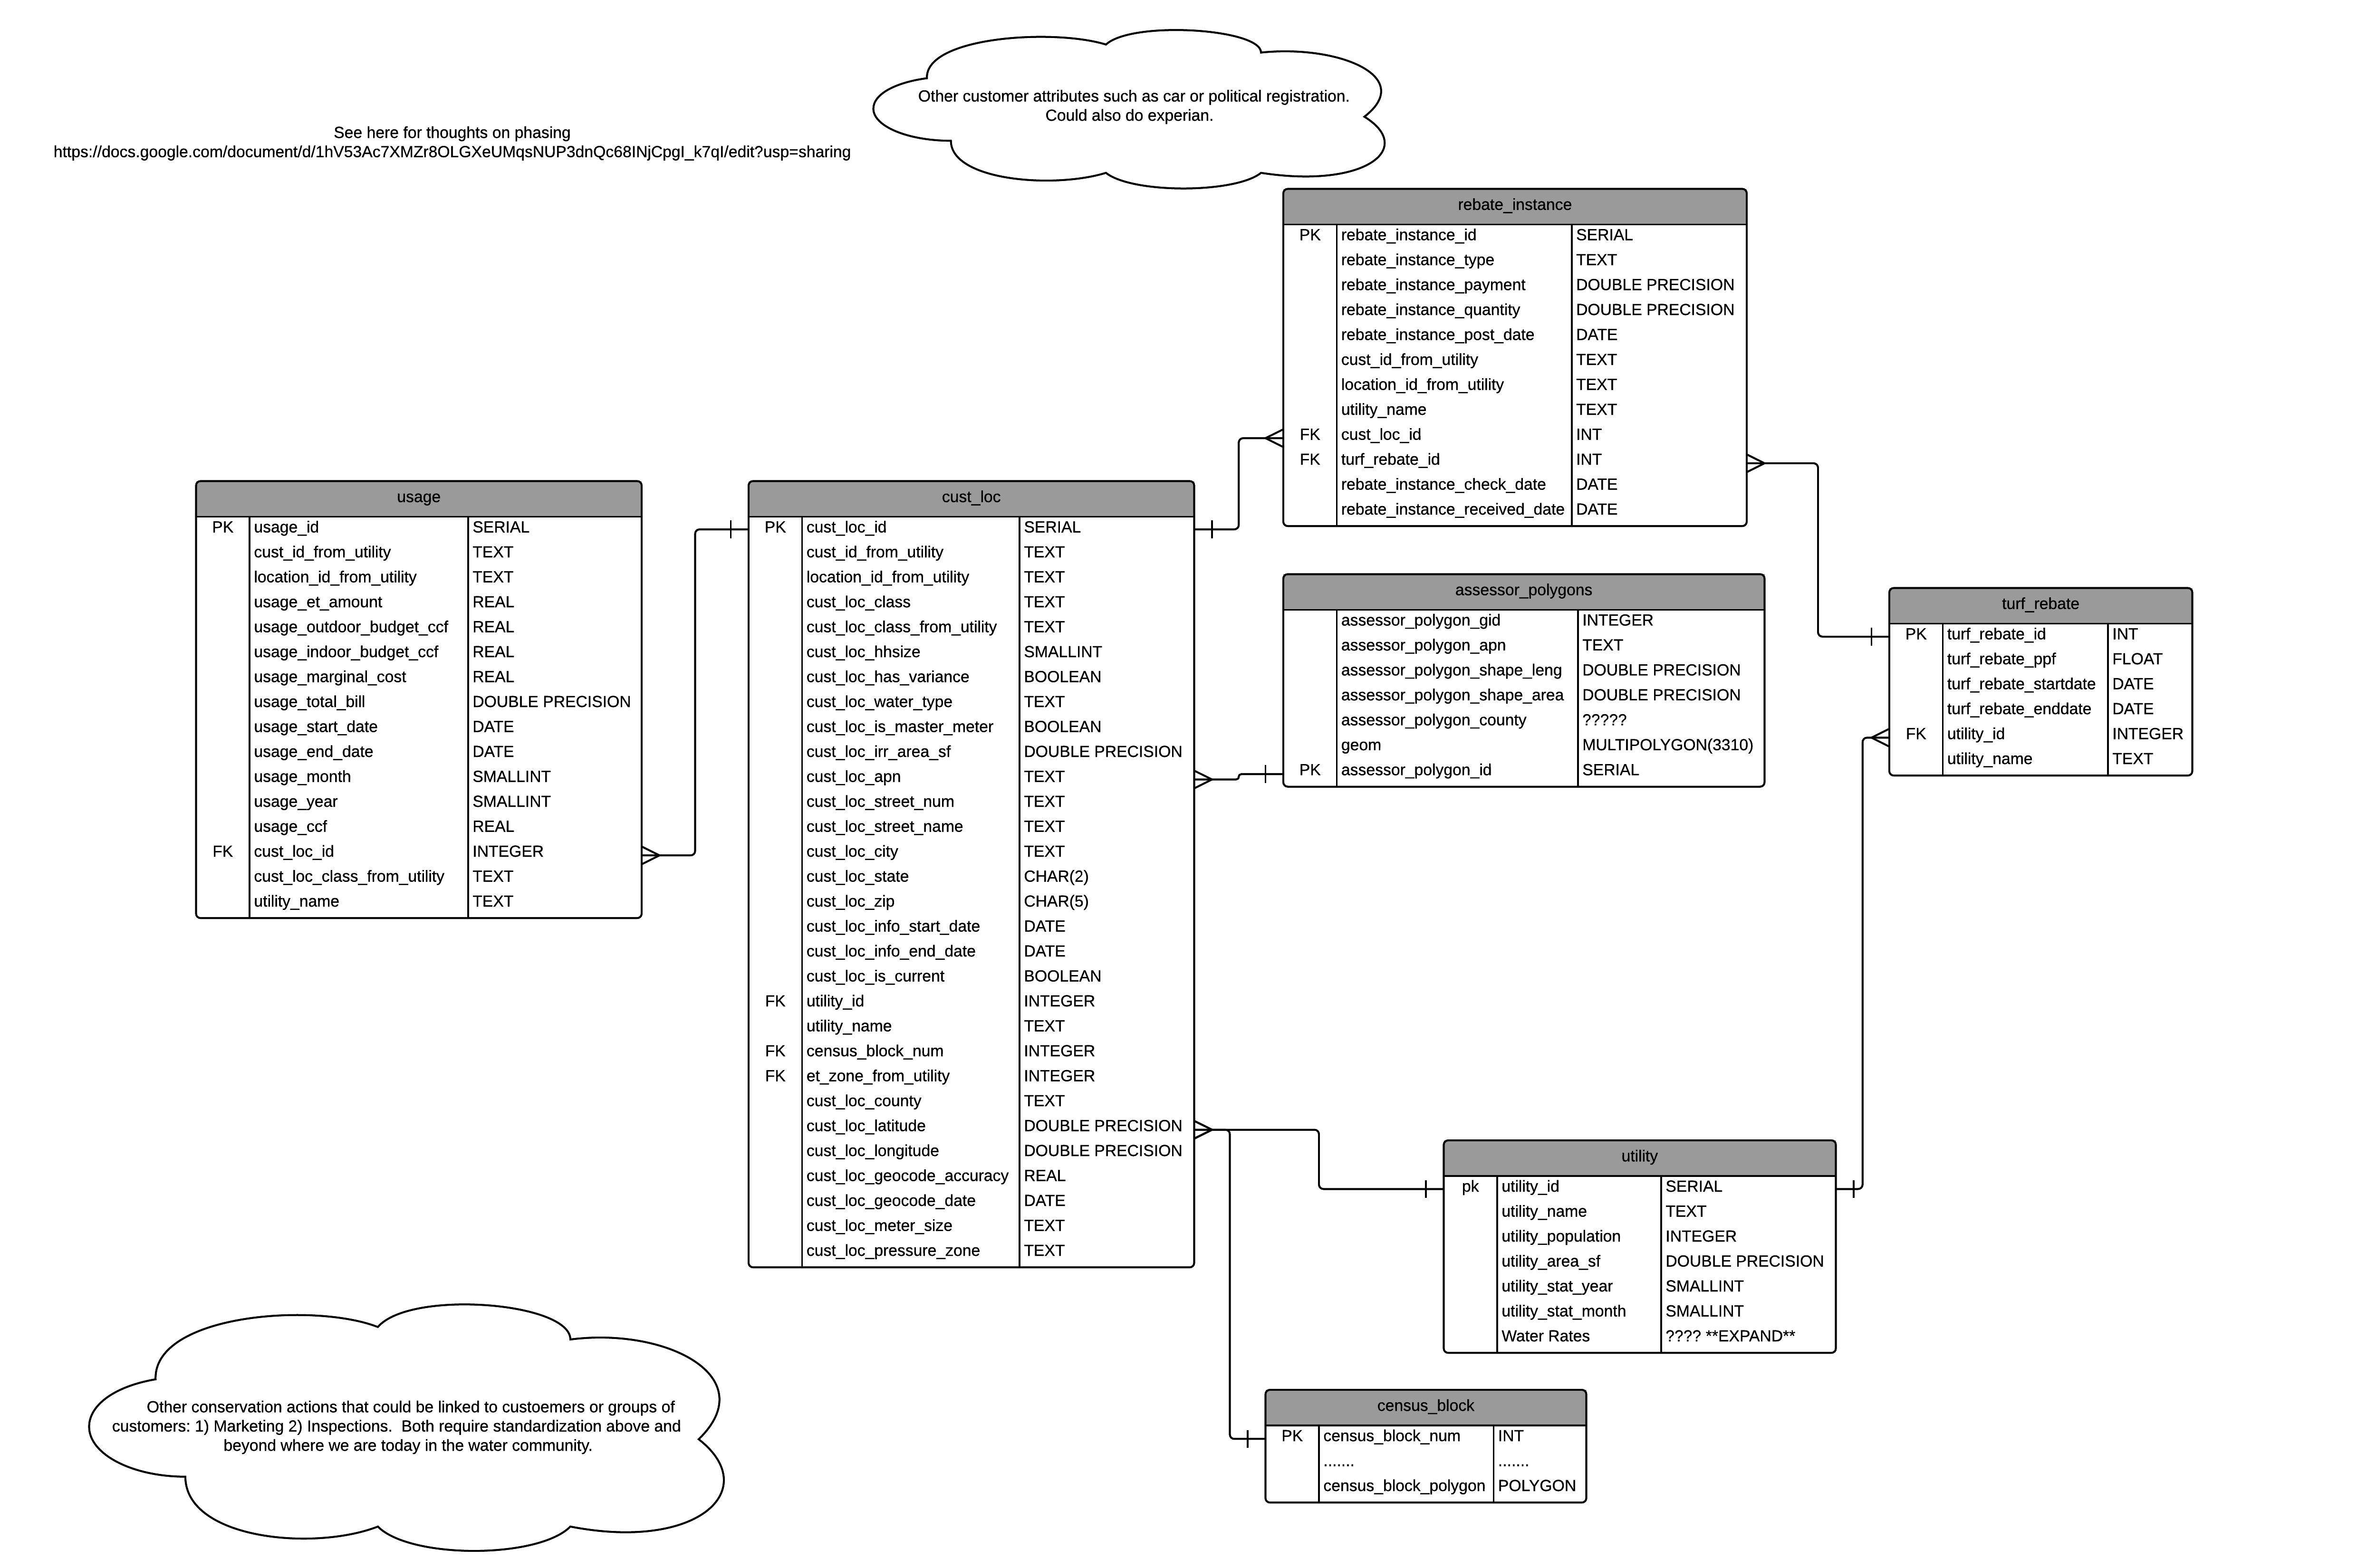

In [81]:
from IPython.display import Image
Image("img/collab_db_schema_v3.png")

---
# DEV

In [146]:
%%bash
## Reference (https://carto.com/blog/data-sync-ogr/)

# # method 2
# # drop old table
# key="dae2d77d6d8f40911576008b6159585c99ab6556" \
# sql="TRUNCATE+TABLE+mnwd_census_block_usage_test" \
# url="http://california-data-collaborative.carto.com:80/api/v2/sql?api_key=$key&q=$sql"
# curl $url

# # load new table
# ogr2ogr \
# -append \
# --config CARTODB_API_KEY $key \
# -f CartoDB \
# "Carto:california-data-collaborative" tempOUT/mnwd_census_block_usage_test.csv

In [ ]:
# # method 3
# # drop old table records
# key="dae2d77d6d8f40911576008b6159585c99ab6556" \
# sql=`echo "TRUNCATE TABLE mnwd_census_block_usage_test" | tr ' ' +` \
# url="http://california-data-collaborative.carto.com:80/api/v2/sql?api_key=$key&q=$sql"
# curl $url

# # load new table
# curl -v -F file=@./tempOUT/temp.csv \
# "https://california-data-collaborative.carto.com/api/v1/imports/?api_key={$key}"

# # populate old table
# sql=`echo "INSERT INTO mnwd_census_block_usage_test SELECT * FROM temp" | tr ' ' +` \
# url="http://california-data-collaborative.carto.com:80/api/v2/sql?api_key=$key&q=$sql"
# curl $url